# импорт

In [5]:
%load_ext autoreload
%autoreload 2

import sys
import os

import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize': (9, 6)})

import pandas as pd
import numpy as np
from tqdm import tqdm, tqdm_notebook
import datetime

from functools import partial
from joblib import Parallel, delayed

import featuretools as ft
import featuretools.variable_types as vtypes

sys.path.append(os.path.join(sys.path[0], '../'))

import libs.config as conf
import libs.data_helpers as dh
import libs.data.featuretools_ds as ft_ds
import libs.data.tsfresh_ds as ts_ds

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# загрузка данных

In [2]:
# train data
events_train = pd.read_csv(f"{conf.DATA_DIR}/event_data_train.zip")
submissions_train = pd.read_csv(f"{conf.DATA_DIR}/submissions_data_train.zip")

# submit data
events_submit = pd.read_csv(f"{conf.DATA_DIR}/events_data_test.zip")
submissions_submit = pd.read_csv(f"{conf.DATA_DIR}/submission_data_test.zip")

# Загрузка информации о курсе
course_df = pd.read_csv(f"{conf.DATA_DIR}/hb_course_info.csv")
for col in ['step_worth', 'step_actions.submit_#']:
    course_df[col] = course_df[col].astype('bool')
course_df.head(3)

,step_id,step_correct_ratio,step_discussions_count,step_has_submissions_restrictions,step_is_solutions_unlocked,lesson_id,step_max_submissions_count,step_passed_by,step_position,step_solutions_unlocked_attempts,...,section_position,section_title,lesson_abuse_count,lesson_discussions_count,lesson_epic_count,lesson_passed_by,lesson_time_to_complete,lesson_title,lesson_viewed_by,lesson_vote_delta
0,32815,NaN,21,False,False,11915,3,18716,1,3,...,1,Предобработка данных,9,2306,179,301,149,Общая информация о курсе,18716,170
1,32811,NaN,1,False,False,11915,3,14936,2,3,...,1,Предобработка данных,9,2306,179,301,149,Общая информация о курсе,18716,170
2,32929,0.989441,3,False,False,11915,3,13073,3,3,...,1,Предобработка данных,9,2306,179,301,149,Общая информация о курсе,18716,170


In [3]:
# параметр колво пользователей по которым генерируем признаки (нужен для теста)
# N_USERS_SAMPLE = 200
N_USERS_SAMPLE = None # должно быть значение None чтобы по всем данным сгенерировать признаки

# featuretools признаки

**Генерация признаков нимает около 20 часов!!!**

Характеристики компьютера: 6 ядер, ОЗУ: 16 ГБ

документация по библиотеке https://github.com/Featuretools/featuretools

## train сгенерируем датасет

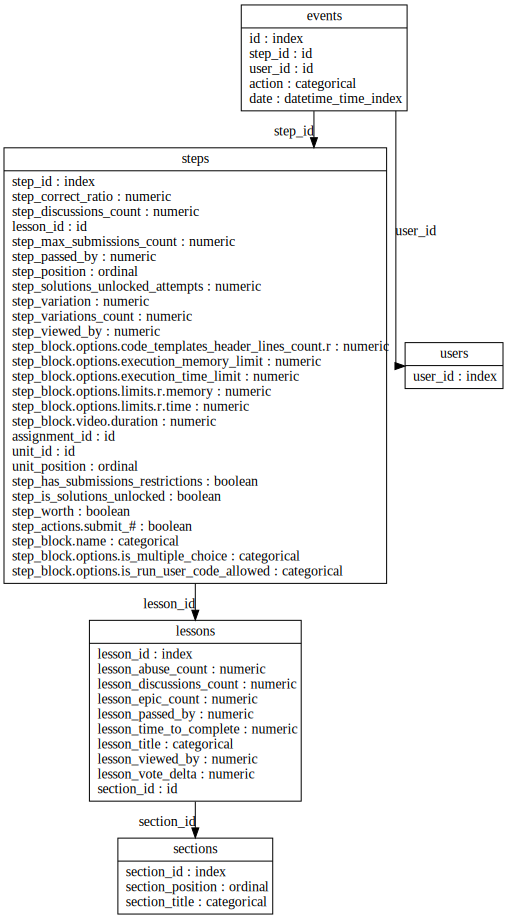

In [6]:
# готовим данные и формируем сущности для featurestools
es_train, cut_off_time_train = ft_ds.prepare_ft(
    events_train, submissions_train, course_df, N_USERS_SAMPLE)
es_train.plot()

In [8]:
# генерируем датасет
feature_matrix_train, feature_defs_train = ft_ds.create_features(
    es_train, cut_off_time_train, n_jobs=6)
print('shape', feature_matrix_train.shape)
feature_matrix_train.head().T

Built 1311 features
EntitySet scattered to 6 workers in 4 seconds
Elapsed: 08:57 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 22/22 chunks


tornado.application - ERROR - Exception in Future <Future cancelled> after timeout
Traceback (most recent call last):
  File "/home/jupyter/ve/lib/python3.6/site-packages/tornado/gen.py", line 936, in error_callback
    future.result()
concurrent.futures._base.CancelledError
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:57124 remote=tcp://127.0.0.1:39625>


shape (192, 1311)


user_id,442,20907,1178,6393,1024
NUM_UNIQUE(events.step_id),19,25,53,28,38
NUM_UNIQUE(events.action),6,3,6,6,6
COUNT(events),96,50,336,114,201
AVG_TIME_BETWEEN(events.date),543.137,3521.69,445.925,1150.71,598.205
TIME_SINCE_FIRST(events.date),172800,172800,172800,172800,172800
TIME_SINCE_LAST(events.date),121202,237,23415,42770,53159
LAST(events.step_id),32950,31978,32244,32031,32206
LAST(events.action),passed,viewed,viewed,viewed,viewed
MODE(events.step_id),31977,31976,32202,31978,32075
MODE(events.action),viewed,viewed,viewed,viewed,viewed


In [ ]:
#  Сохраняем даныне
# feature_matrix_train.to_csv(
#     f"{conf.PROCESSED_DATA_DIR}/step_features_train_ft3.csv.zip",
#     index=True,
#     compression='zip')

## submit сгенерируем датасет

In [7]:
es_submit, cut_off_time_submit = ft_ds.prepare_ft(events_submit, submissions_submit, course_df,
                                    N_USERS_SAMPLE)

In [7]:
feature_matrix_submit, feature_defs_submit = ft_ds.create_features(es_submit, cut_off_time_submit, n_jobs=6)
feature_matrix_submit.head().T

Built 1311 features
EntitySet scattered to 6 workers in 3 seconds
Elapsed: 09:36 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 21/21 chunks


Exception ignored in: <generator object add_client at 0x7f85f414afc0>
RuntimeError: generator ignored GeneratorExit
tornado.application - ERROR - Exception in Future <Future cancelled> after timeout
Traceback (most recent call last):
  File "/home/jupyter/ve/lib/python3.6/site-packages/tornado/gen.py", line 936, in error_callback
    future.result()
concurrent.futures._base.CancelledError


user_id,17391,22297,18342,1472,23841
NUM_UNIQUE(events.step_id),32,13,27,27,42
NUM_UNIQUE(events.action),6,3,6,6,6
COUNT(events),192,37,111,123,261
AVG_TIME_BETWEEN(events.date),633.754,0.361111,683.273,1293.98,664.515
TIME_SINCE_FIRST(events.date),172800,172800,172800,172800,172800
TIME_SINCE_LAST(events.date),51753,172787,97640,14935,26
LAST(events.step_id),33272,32187,32176,32950,32178
LAST(events.action),passed,passed,passed,viewed,passed
MODE(events.step_id),31976,31956,32219,31978,32173
MODE(events.action),viewed,discovered,viewed,viewed,viewed


In [ ]:
# feature_matrix_submit.to_csv(
#     f"{conf.PROCESSED_DATA_DIR}/step_features_submit_ft3.csv.zip",
#     index=True,
#     compression='zip')

# tsfresh генерация признаков по временным рядам

Генерация занимает примерно 5-10 минут

Документация https://tsfresh.readthedocs.io/en/latest/

## train

In [10]:
interact_train = dh.create_interaction(dh.truncate_data_by_nday(events_train, conf.DATA_PERIOD_DAYS),
                                    dh.truncate_data_by_nday(submissions_train, conf.DATA_PERIOD_DAYS))
interact_train = dh.preprocess_timestamp_cols(interact_train)
ts_data_train = ts_ds.prep_ts_interact(interact_train)
ts_data_train = ts_ds.gen_ts_features(ts_data_train)

Index(['step_id', 'timestamp', 'action', 'user_id', 'date', 'day'], dtype='object')


Feature Extraction: 100%|██████████| 23081/23081 [03:25<00:00, 112.49it/s]


In [ ]:
# ts_data_train.to_csv(
#     f"{conf.PROCESSED_DATA_DIR}/ts_features_train.zip",
#     index=True,
#     compression='zip')

## submission

In [17]:
interact_submit = dh.create_interaction(events_submit, submissions_submit)
interact_submit = dh.preprocess_timestamp_cols(interact_submit)
ts_data_submit = ts_ds.prep_ts_interact(interact_submit)
ts_data_submit = ts_ds.gen_ts_features(ts_data_submit)

Feature Extraction: 100%|██████████| 7421/7421 [01:00<00:00, 121.94it/s]


In [ ]:
# ts_data_submit.to_csv(
#     f"{conf.PROCESSED_DATA_DIR}/ts_features_submit.zip",
#     index=True,
#     compression='zip')